# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import tensorflow as tf
import numpy as np
import cv2
import os

from pycocotools.coco import COCO
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, ReLU
from tensorflow.keras.models import Model


# Semantic Segmentation Architecture

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 4

class CocoSemanticGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_dir, ann_file):
        self.coco = COCO(ann_file)
        self.image_dir = image_dir
        self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)//BATCH_SIZE

    def __getitem__(self, idx):

        batch_ids = self.ids[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]

        images = []
        masks = []

        for img_id in batch_ids:

            info = self.coco.loadImgs(img_id)[0]
            path = os.path.join(self.image_dir, info['file_name'])

            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))/255.0

            mask = np.zeros((info['height'],info['width']),dtype=np.uint8)

            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)

            # SINGLE CLASS
            for ann in anns:
                m = self.coco.annToMask(ann)
                mask[m==1] = 1

            mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask,-1)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters,(3,3),padding="same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)

    conv2 = Conv2D(filters,(3,3),padding="same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)

    return act2

In [ ]:
def encoder(entered_input, filters=64):

    enc = convolution_operation(entered_input,filters)
    pool = MaxPooling2D(strides=(2,2))(enc)

    return enc,pool

In [ ]:
def decoder(entered_input, skip, filters=64):

    up = Conv2DTranspose(filters,(2,2),strides=2,padding="same")(entered_input)
    merge = Concatenate()([up,skip])
    out = convolution_operation(merge,filters)

    return out

In [ ]:
def UNet():

    inputs = Input((224,224,3))

    enc1,pool1 = encoder(inputs,64)
    enc2,pool2 = encoder(pool1,128)
    enc3,pool3 = encoder(pool2,256)
    enc4,pool4 = encoder(pool3,512)

    bridge = convolution_operation(pool4,1024)

    dec4 = decoder(bridge,enc4,512)
    dec3 = decoder(dec4,enc3,256)
    dec2 = decoder(dec3,enc2,128)
    dec1 = decoder(dec2,enc1,64)

    # single-class output
    outputs = Conv2D(1,(1,1),activation="sigmoid")(dec1)

    model = Model(inputs,outputs)
    return model

In [ ]:
model = UNet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Train

In [ ]:
BASE_PATH = "/content/drive/MyDrive/PLANKTON/data/instance/instance-t20.v2i.coco-segmentation/"

train_gen = CocoSemanticGenerator(
    image_dir = f"{BASE_PATH}/train/images",
    ann_file = f"{BASE_PATH}/train/_annotations.coco.json"
)

valid_gen = CocoSemanticGenerator(
    image_dir = f"{BASE_PATH}/valid/images",
    ann_file = f"{BASE_PATH}/valid/_annotations.coco.json"
)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=2.33s)
creating index...
index created!


In [ ]:
model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6499 - loss: 0.6887 - val_accuracy: 0.8286 - val_loss: 0.6779
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.9295 - loss: 0.3340 - val_accuracy: 0.2127 - val_loss: 1.3085
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.9257 - loss: 0.2639 - val_accuracy: 0.9264 - val_loss: 0.4111
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.9340 - loss: 0.2349 - val_accuracy: 0.9264 - val_loss: 0.3199
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.9449 - loss: 0.1974 - val_accuracy: 0.4698 - val_loss: 0.8209
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.9537 - loss: 0.1820 - val_accuracy: 0.9264 - val_loss: 0.2662
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9366 - loss: 0.2001 - val_accuracy: 0.9264 - val_loss: 0.2638
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9465 - loss: 0.1885 - val_accuracy: 0.9

# Val

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Text(0.5, 1.0, 'Prediction')

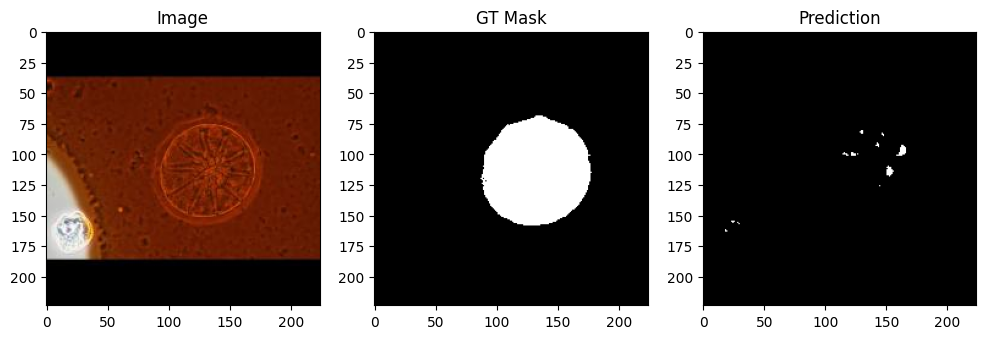

In [12]:
import matplotlib.pyplot as plt

imgs, masks = valid_gen[0]
preds = model.predict(imgs)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(imgs[0])
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(masks[0].squeeze(), cmap="gray")
plt.title("GT Mask")

plt.subplot(1,3,3)
plt.imshow((preds[0]>0.5).squeeze(), cmap="gray")
plt.title("Prediction")

In [13]:
def dice_score(y_true, y_pred, smooth=1e-6):

    y_true = tf.cast(tf.reshape(y_true,[-1]), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred,[-1]), tf.float32)

    intersection = tf.reduce_sum(y_true*y_pred)

    return (2*intersection+smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

In [14]:
for imgs, masks in valid_gen:
    preds = model.predict(imgs)
    print(dice_score(masks, preds>0.5))
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
tf.Tensor(0.1677106, shape=(), dtype=float32)


In [15]:
model.save("unet_baseline.keras")